# I. Importing the required libraries

In [1]:


import os
import random
import sys

## Package
import glob 
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns
import scipy.io.wavfile


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

import pickle


from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
input_duration=3

# II. Reading the data

In [2]:

# Data Directory
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

dir_list1 = os.listdir('data1/')
dir_list1.sort()
print (dir_list1)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
['Actor_25', 'Actor_26', 'Actor_27', 'Actor_28']


# Creating dataframe

In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        emotion = int(nm[2])
            
        data_df.loc[count] = [path, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


,path,emotion
0,data/Actor_01/03-01-01-01-01-01-01.wav,1
1,data/Actor_01/03-01-01-01-01-02-01.wav,1
2,data/Actor_01/03-01-01-01-02-01-01.wav,1
3,data/Actor_01/03-01-01-01-02-02-01.wav,1
4,data/Actor_01/03-01-02-01-01-01-01.wav,2


In [5]:
# All class

label_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "neutral"
    elif data_df.emotion[i] == 3:
        lb = "happy"
    elif data_df.emotion[i] == 4:
        lb = "sad"
    elif data_df.emotion[i] == 5:
        lb = "angry"
    else:
        lb = "none"
        
    # Add gender to the label 
    label_list.append(lb)
    
len(label_list)

1440

In [6]:
# Select the label set you want by commenting the unwanteds.
data_df['label'] = label_list
data_df.head()

,path,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,neutral
4,data/Actor_01/03-01-02-01-01-01-01.wav,2,none


In [7]:
data_df=data_df.drop(columns=['emotion'])

In [8]:
#dropping the female_none and male_none
data_df = data_df[data_df.label != 'none'].reset_index(drop=True)
data_df.label.value_counts()

happy      192
angry      192
sad        192
neutral     96
Name: label, dtype: int64

In [9]:
len(data_df)
data_df.head()

,path,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,neutral
4,data/Actor_01/03-01-03-01-01-01-01.wav,happy


In [10]:
# Create DataFrame for Data
data_df1 = pd.DataFrame(columns=['path', 'label'])
count = 0
for i in dir_list1:
    file_list = os.listdir('data1/' + i)
    for f in file_list:
        nm = f.split('.')[0]
        path = 'data1/' + i + '/' + f
        src = nm[0]
        if nm[0]=='a':
            lb="angry"
        elif nm[0]=='h':
            lb = "happy"
        elif nm[0]=='s':
            lb = "sad"
        elif nm[0]=='n':
            lb = "neutral"
        
            
        data_df1.loc[count] = [path, lb]
        count += 1

In [11]:
data_df1.head()
print(data_df1.label.value_counts())
print(data_df.label.value_counts())

neutral    120
happy       60
sad         60
angry       60
Name: label, dtype: int64
happy      192
angry      192
sad        192
neutral     96
Name: label, dtype: int64


In [12]:
data = pd.concat([data_df, data_df1], axis=0, sort=True).reset_index(drop=True)

In [13]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

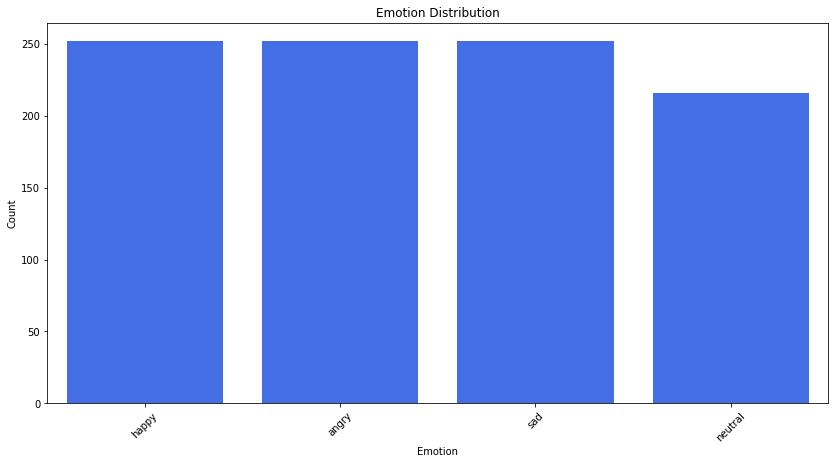

In [14]:
a = data.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [15]:
len(data)

972

In [16]:
filename = data.path[870]
print (filename)

samples, sample_rate = librosa.load(filename, sr=16000)
sample_rate,samples
Audio(data=samples,rate=sample_rate)

data1/Actor_27/n19.wav


# III. Separating the dataset for different emotion

In [17]:
#happy dataset
df_happy=data[data.label=='happy']
df_happy=df_happy.reset_index(drop=True)
print(df_happy.head())

#angry dataset
df_angry=data[data.label=='angry']
df_angry=df_angry.reset_index(drop=True)
print(df_angry.head())

#sad dataset
df_sad=data[data.label=='sad']
df_sad=df_sad.reset_index(drop=True)
print(df_sad.head())

#neutral dataset
df_neutral=data[data.label=='neutral']
df_neutral=df_neutral.reset_index(drop=True)
print(df_neutral.head())


   label                                    path
0  happy  data/Actor_01/03-01-03-01-01-01-01.wav
1  happy  data/Actor_01/03-01-03-01-01-02-01.wav
2  happy  data/Actor_01/03-01-03-01-02-01-01.wav
3  happy  data/Actor_01/03-01-03-01-02-02-01.wav
4  happy  data/Actor_01/03-01-03-02-01-01-01.wav
   label                                    path
0  angry  data/Actor_01/03-01-05-01-01-01-01.wav
1  angry  data/Actor_01/03-01-05-01-01-02-01.wav
2  angry  data/Actor_01/03-01-05-01-02-01-01.wav
3  angry  data/Actor_01/03-01-05-01-02-02-01.wav
4  angry  data/Actor_01/03-01-05-02-01-01-01.wav
  label                                    path
0   sad  data/Actor_01/03-01-04-01-01-01-01.wav
1   sad  data/Actor_01/03-01-04-01-01-02-01.wav
2   sad  data/Actor_01/03-01-04-01-02-01-01.wav
3   sad  data/Actor_01/03-01-04-01-02-02-01.wav
4   sad  data/Actor_01/03-01-04-02-01-01-01.wav
     label                                    path
0  neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1  neutral  data/Actor

In [18]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav


Text(0.5,0,'Seconds')

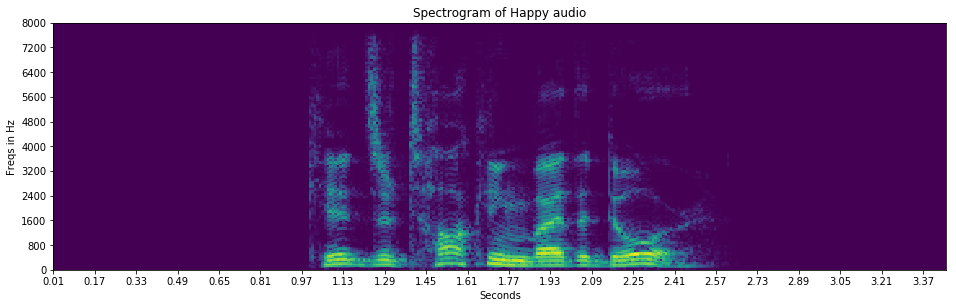

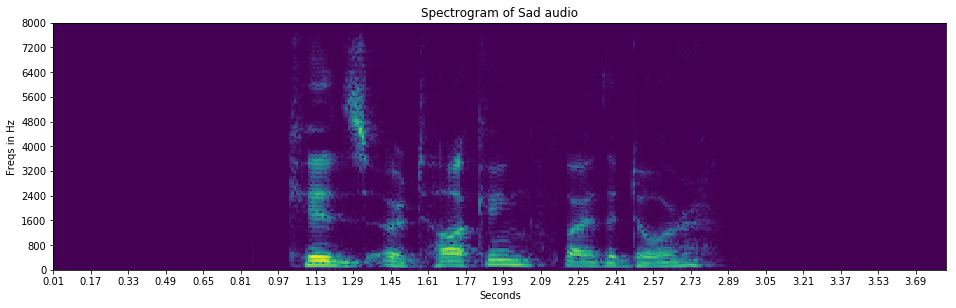

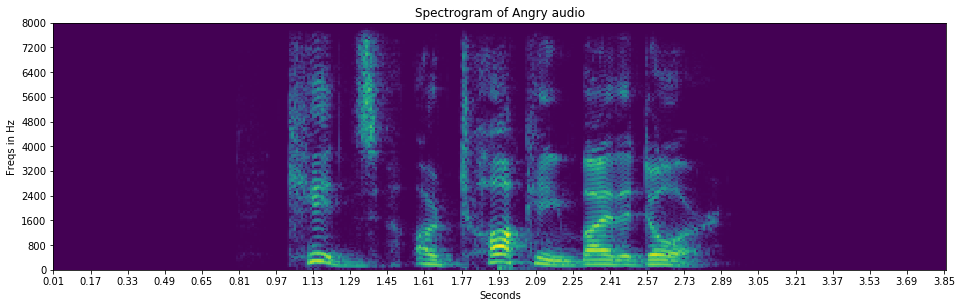

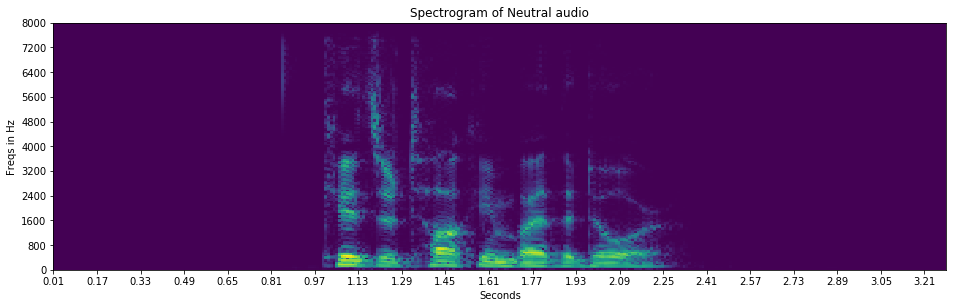

In [19]:
samples, sample_rate = librosa.load(df_happy.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Happy audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_sad.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Sad audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_angry.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Angry audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_neutral.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Neutral audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# IV. Data Splitting

In [20]:
#  Stratified Shuffle Split Method
def data_split(X,Y):
    xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
    for train_index, test_index in xxx.split(X, Y):
        train, test = X.iloc[train_index], X.iloc[test_index]
        label_train, label_test = Y.iloc[train_index], Y.iloc[test_index]
    df=pd.DataFrame(columns=["path"])
    df=pd.DataFrame(train)
    df=df.reset_index(drop=True)
    test=test.reset_index(drop=True)
    label_test=label_test.reset_index(drop=True)
    return (df,test,label_test)

In [21]:
#happy dataset splitting
X=df_happy["path"]
Y=df_happy["label"]

d_happy,happy_test,happy_label_test=data_split(X,Y)

## sad dataset splitting
X=df_sad["path"]
Y=df_sad["label"]
d_sad,sad_test,sad_label_test=data_split(X,Y)



## angry dataset splitting
X=df_angry["path"]
Y=df_angry["label"]
d_angry,angry_test,angry_label_test=data_split(X,Y)

## sad dataset splitting
X=df_neutral["path"]
Y=df_neutral["label"]
d_neutral,neutral_test,neutral_label_test=data_split(X,Y)

test = pd.concat([happy_test,sad_test, angry_test,neutral_test], axis=0, sort=True).reset_index(drop=True)
test_label = pd.concat([happy_label_test, sad_label_test, angry_label_test, neutral_label_test], axis=0, sort=True).reset_index(drop=True)


# IV. Feature Extraction

In [22]:
def feature_extraction(df):
    data = np.asarray(())
    for i in tqdm(range(len(df))):
        X, sample_rate = librosa.load(df.path[i], res_type='kaiser_fast',duration=input_duration,sr=16000,offset=0.5)

        sample_rate = np.array(sample_rate)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, hop_length=int(0.010*sample_rate), n_fft=int(0.020*sample_rate), n_mfcc=13)
        feature = mfccs.transpose()
        mfcc_delta=librosa.feature.delta(feature)
        mfcc_delta2=librosa.feature.delta(feature, order=2)
        ener = librosa.feature.rmse(y=X, frame_length= int(0.020*sample_rate), hop_length = int(0.010* sample_rate))
        ener=ener.transpose()
        feature= np.hstack((feature, mfcc_delta, mfcc_delta2, ener))
        if data.size==0:
            data = feature
        else:
            data = np.vstack((data,feature))
            
    return np.array(data)

In [23]:
#Feature extraction for happy dataset    
happy=feature_extraction(d_happy)

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  0%|▍                                                                                 | 1/201 [00:00<03:08,  1.06it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 15%|████████████▍                                                                    | 31/201 [00:02<00:10, 15.99it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 30%|████████████████████████▏                                                        | 60/201 [00:03<00:07, 19.31it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 31%|████████████████████████▉                                                        | 62/201 [00:04<00:07, 19.01it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 45%|████████████████████████████████████▎                                            | 90/201 [00:05<00:05, 18.63it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 46%|█████████████████████████████████████                                            | 92/201 [00:05<00:05, 18.19it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 60%|███████████████████████████████████████████████▊                                | 120/201 [00:07<00:05, 15.87it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▌                               | 122/201 [00:07<00:04, 16.34it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 75%|███████████████████████████████████████████████████████████▋                    | 150/201 [00:09<00:02, 17.07it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 76%|████████████████████████████████████████████████████████████▍                   | 152/201 [00:09<00:02, 17.25it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [24]:
happy

array([[-9.29953067e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  3.65560072e-06],
       [-9.29953067e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.35656272e-06],
       [-9.28116845e+02,  2.59222855e+00,  2.57851222e+00, ...,
        -7.43849442e-03, -7.43849442e-03,  1.27692956e-05],
       ...,
       [-9.79993666e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  2.20014749e-06],
       [-9.79993666e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  3.45904959e-06],
       [-9.79993666e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.31139858e-06]])

In [25]:
#Feature Extraction for angry dataset
angry=feature_extraction(d_angry)

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in m

 29%|███████████████████████▎                                                         | 58/201 [00:03<00:07, 19.27it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 30%|████████████████████████▌                                                        | 61/201 [00:03<00:07, 19.45it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 44%|███████████████████████████████████▍                                             | 88/201 [00:04<00:06, 18.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 45%|████████████████████████████████████▎                                            | 90/201 [00:04<00:05, 18.62it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 59%|██████████████████████████████████████████████▉                                 | 118/201 [00:06<00:04, 16.92it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 60%|███████████████████████████████████████████████▊                                | 120/201 [00:06<00:04, 16.94it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 73%|██████████████████████████████████████████████████████████▌                     | 147/201 [00:08<00:03, 16.71it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 149/201 [00:08<00:03, 16.78it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 88%|██████████████████████████████████████████████████████████████████████▍         | 177/201 [00:09<00:01, 15.19it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 89%|███████████████████████████████████████████████████████████████████████▏        | 179/201 [00:10<00:01, 15.42it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [26]:
#Feature extraction for sad emotion
sad=feature_extraction(d_sad)   

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in m

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 29%|███████████████████████▊                                                         | 59/201 [00:03<00:07, 19.19it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 30%|████████████████████████▌                                                        | 61/201 [00:03<00:07, 19.04it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 44%|███████████████████████████████████▊                                             | 89/201 [00:04<00:06, 18.17it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 45%|████████████████████████████████████▋                                            | 91/201 [00:04<00:06, 18.02it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 73%|██████████████████████████████████████████████████████████▌                     | 147/201 [00:08<00:03, 16.44it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 149/201 [00:08<00:03, 16.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [27]:
#Feature extraction for neutral emotion
neutral=feature_extraction(d_neutral)  

  0%|                                                                                          | 0/172 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▉                                                                                 | 2/172 

 17%|█████████████▋                                                                   | 29/172 [00:01<00:07, 19.72it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 19%|███████████████                                                                  | 32/172 [00:01<00:06, 20.16it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 36%|█████████████████████████████▏                                                   | 62/172 [00:03<00:05, 20.58it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 53%|███████████████████████████████████████████▎                                     | 92/172 [00:04<00:03, 20.20it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 55%|████████████████████████████████████████████▋                                    | 95/172 [00:04<00:03, 19.40it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 72%|█████████████████████████████████████████████████████████▋                      | 124/172 [00:06<00:02, 19.46it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 88%|██████████████████████████████████████████████████████████████████████▋         | 152/172 [00:07<00:01, 18.52it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 90%|███████████████████████████████████████████████████████████████████████▋        | 154/172 [00:07<00:00, 18.44it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

# Training

In [28]:
def train_model(features):
    gmm = GaussianMixture(n_components=512).fit(features)
    labels = gmm.predict(features)
    return (gmm,labels)

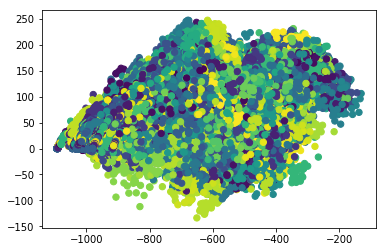

In [65]:
#happy model
gmm_happy,labels=train_model(happy)
plt.scatter(happy[:, 0], happy[:, 1], c=labels, s=40, cmap='viridis');


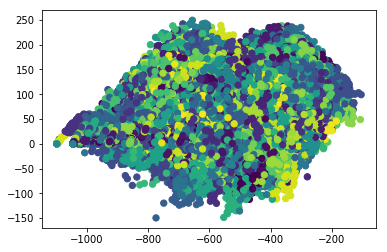

In [66]:
#angry model
gmm_angry,labels= train_model(angry)
plt.scatter(angry[:, 0], angry[:, 1], c=labels, s=40, cmap='viridis');

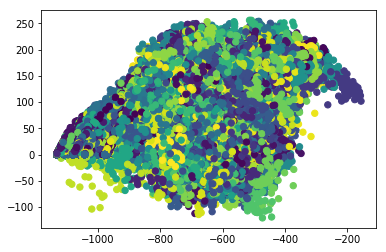

In [67]:
#sad model
gmm_sad,labels= train_model(sad)
plt.scatter(sad[:, 0], sad[:, 1], c=labels, s=40, cmap='viridis');

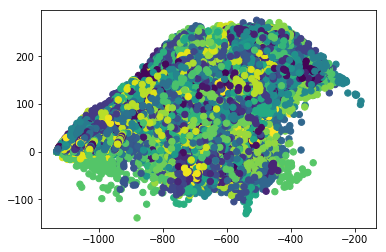

In [68]:
#neutral model
gmm_neutral,labels = train_model(neutral)
plt.scatter(neutral[:, 0], neutral[:, 1], c=labels, s=40, cmap='viridis');

# Save Model

In [29]:
def save_model(model,name):
    save_dir = os.path.join(os.getcwd(), 'AnotherCombinedModels')
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = name+'.sav'
    model_path = os.path.join(save_dir, filename)
    print(model_path)
    pickle.dump(model, open(model_path, 'wb'))

In [113]:
#save happy model
save_model(gmm_happy, "happy_model")
#save angry model
save_model(gmm_angry, "angry_model")
#save sad model
save_model(gmm_sad, "sad_model")
#save neutral model
save_model(gmm_neutral, "neutral_model")

In [111]:
pd.DataFrame(neutral)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1036.669274,6.527079,6.138234,5.545126,4.816583,4.026506,3.240610,2.508344,1.861331,1.316996,0.884196,0.567402,0.367310
1,-1033.344230,10.266990,8.763979,9.057156,9.934012,9.095528,7.333748,7.028824,7.802961,7.260691,5.417129,4.707826,5.537139
2,-1041.380460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-1041.380460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-1041.380460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-1035.337580,8.124980,7.579073,7.759319,8.132548,7.790227,7.077298,6.887876,7.037035,6.705215,5.986730,5.621499,5.550790
6,-1034.708943,8.957307,8.301192,8.431469,8.855980,8.575307,7.794511,7.404641,7.423517,7.190396,6.616390,6.118748,5.721217
7,-1041.380460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,-1040.729044,0.920616,0.918744,0.915627,0.911269,0.905676,0.898856,0.890817,0.881572,0.871131,0.859510,0.846724,0.832791
9,-1035.248578,8.394062,7.851714,7.516879,7.481737,7.502563,7.329403,6.814072,5.989578,5.192609,4.794049,4.691290,4.386205


In [70]:
neutral[:,0]

array([-1036.66927364, -1033.34423006, -1041.38045953, ...,
        -941.42159402,  -948.68094865,  -941.09703582])

# Load Model

In [43]:
def load_model(name):
    with open('CombinedModels/'+name+".sav", 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [44]:
gmm_happy= load_model("happy_model")
gmm_angry= load_model("angry_model")
gmm_sad=load_model("sad_model")
gmm_neutral=load_model("neutral_model")

In [45]:
def test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,data):
    predict = pd.DataFrame(columns=['predict'])
    for i in tqdm(range(len(data))):
        X, sample_rate = librosa.load(data[i], res_type='kaiser_fast',duration=input_duration,sr=16000,offset=0.5)

        sample_rate = np.array(sample_rate)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, hop_length=int(0.010*sample_rate), n_fft=int(0.020*sample_rate), n_mfcc=13)
        feature = mfccs.transpose()
        mfcc_delta=librosa.feature.delta(feature)
        mfcc_delta2=librosa.feature.delta(feature, order=2)
        ener = librosa.feature.rmse(y=X, frame_length= int(0.020*sample_rate), hop_length = int(0.010* sample_rate))
        ener=ener.transpose()
        feature= np.hstack((feature, mfcc_delta, mfcc_delta2, ener))
        happy_score= gmm_happy.score(feature)
        angry_score= gmm_angry.score(feature)
        sad_score= gmm_sad.score(feature)
        neutral_score= gmm_neutral.score(feature)
        dicta = {
            "happy": happy_score,
            "angry": angry_score,
            "sad": sad_score,
            "neutral": neutral_score
        }
        x=max(dicta, key=dicta.get)
        predict.loc[i]=x
    return predict

In [46]:
#happy_test   
happy_predict  =  test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,happy_test)

  0%|                                                                                           | 0/51 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  2%|█▋                                                                                 | 1/51 [00:00<00:18,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

 45%|████████████████████████████████████▉                                             | 23/51 [00:08<00:10,  2.65it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 47%|██████████████████████████████████████▌                                           | 24/51 [00:09<00:10,  2.67it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|████████████████████████████████████████▏                                         | 25/51 [00:09<00:09,  2.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 92%|███████████████████████████████████████████████████████████████████████████▌      | 47/51 [00:17<00:01,  2.61it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 48/51 [00:18<00:01,  2.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 96%|██████████████████████████████████████████████████████████████████████████████▊   | 49/51 [00:18<00:00,  2.58it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

In [41]:
happy_predict.predict.value_counts()

happy    48
angry     2
sad       1
Name: predict, dtype: int64

In [42]:
#angry test   
angry_predict = test_model(angry_test)

TypeError: test_model() missing 4 required positional arguments: 'gmm_angry', 'gmm_sad', 'gmm_neutral', and 'data'

In [ ]:
angry_predict.predict.value_counts()

In [ ]:
#sad test
sad_predict = test_model(sad_test)

In [ ]:
sad_predict.predict.value_counts()

In [ ]:
#Neutral Test
neutral_predict = test_model(neutral_test)   

In [ ]:
neutral_predict.predict.value_counts()

In [ ]:
#total test for test data set 
    
predict  = test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,test)  

  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  1%|▍                                                                                 | 1/197 [00:00<01:11,  2.74it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

 12%|█████████▍                                                                       | 23/197 [00:08<01:08,  2.52it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 12%|█████████▊                                                                       | 24/197 [00:09<01:06,  2.59it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:09<01:07,  2.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▎                                                             | 47/197 [00:17<00:55,  2.72it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 24%|███████████████████▋                                                             | 48/197 [00:18<00:54,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:18<00:54,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 36%|█████████████████████████████▏                                                   | 71/197 [00:36<03:16,  1.56s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|█████████████████████████████▌                                                   | 72/197 [00:38<03:17,  1.58s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:40<03:20,  1.61s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 48%|███████████████████████████████████████                                          | 95/197 [01:17<02:53,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▍                                         | 96/197 [01:18<02:51,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [01:20<02:51,  1.71s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 60%|████████████████████████████████████████████████▎                               | 119/197 [01:55<02:05,  1.61s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▋                               | 120/197 [01:57<02:07,  1.66s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [01:58<02:03,  1.62s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████                      | 143/197 [02:34<01:24,  1.56s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [02:35<01:23,  1.57s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [02:37<01:21,  1.56s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|███████████████████████████████████████████████████████████████████▊            | 167/197 [03:12<00:51,  1.71s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [03:14<00:48,  1.67s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [03:14<00:36,  1.29s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

In [ ]:
predict.head()

In [ ]:
predict.predict.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix
# c=confusion_matrix(test_label, predict)
# c

In [ ]:
test_label

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:


labels=["angry","sad","neutral","happy"]

plot_confusion_matrix(cm = c, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")


In [ ]:

plot_confusion_matrix(cm = c, 
                      normalize    = True,
                      target_names = labels,
                      title        = "Confusion Matrix")

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
accuracy(c)

In [36]:
while(True):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-36-bfea918c25ae>, line 2)

In [ ]:
data, sampling_rate = librosa.load('output.wav')

In [33]:
X, sample_rate = librosa.load('output.wav', res_type='kaiser_fast',duration=input_duration,sr=16000,offset=0.5)

sample_rate = np.array(sample_rate)
mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, hop_length=int(0.010*sample_rate), n_fft=int(0.020*sample_rate), n_mfcc=13)
feature = mfccs.transpose()
happy_score= gmm_happy.score(feature)
angry_score= gmm_angry.score(feature)
sad_score= gmm_sad.score(feature)
neutral_score= gmm_neutral.score(feature)
dicta = {
    "happy": happy_score,
    "angry": angry_score,
    "sad": sad_score,
    "neutral": neutral_score
}
record=max(dicta, key=dicta.get)


E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.



NameError: name 'gmm_happy' is not defined

In [36]:
## Run Continuously until you find good result
while(True):
    gmm_happy,label1=train_model(happy)
    gmm_angry,label2=train_model(angry)
    gmm_sad,label3=train_model(sad)
    gmm_neutral,label4=train_model(neutral)
    
    predict  = test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,test)
    
    c=confusion_matrix(test_label, predict)
    
    acc=accuracy(c)
    if acc >= 0.89:
        #save happy model
        save_model(gmm_happy, "happy_model")
        #save angry model
        save_model(gmm_angry, "angry_model")
        #save sad model
        save_model(gmm_sad, "sad_model")
        #save neutral model
        save_model(gmm_neutral, "neutral_model")
        break
    print(acc)
    

  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  1%|▍                                                                                 | 1/197 [00:00<03:14,  1.01it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

 12%|█████████▍                                                                       | 23/197 [00:09<01:04,  2.71it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 12%|█████████▊                                                                       | 24/197 [00:09<01:03,  2.72it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:09<01:02,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▎                                                             | 47/197 [00:17<00:54,  2.77it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 24%|███████████████████▋                                                             | 48/197 [00:18<00:53,  2.77it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:18<00:53,  2.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 36%|█████████████████████████████▏                                                   | 71/197 [00:26<00:45,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|█████████████████████████████▌                                                   | 72/197 [00:26<00:45,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:27<00:44,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 48%|███████████████████████████████████████                                          | 95/197 [00:35<00:36,  2.79it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▍                                         | 96/197 [00:35<00:36,  2.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [00:35<00:36,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 60%|████████████████████████████████████████████████▎                               | 119/197 [00:43<00:28,  2.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▋                               | 120/197 [00:44<00:27,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [00:44<00:28,  2.71it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████                      | 143/197 [00:52<00:19,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [00:53<00:19,  2.78it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [00:53<00:19,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|███████████████████████████████████████████████████████████████████▊            | 167/197 [01:00<00:09,  3.06it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [01:01<00:09,  2.94it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [01:01<00:08,  3.40it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 191/197 [01:09<00:02,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [01:09<00:01,  2.92it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [01:09<00:01,  2.89it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

0.817258883248731


  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▍                                                                                 | 1/197 [00:00<01:11,  2.74it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▊                                                                                 | 2/197 [00:00<01:10,  2.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 12%|█████████▊                                                                       | 24/197 [00:08<01:02,  2.79it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:08<01:01,  2.79it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▋                                                                      | 26/197 [00:09<01:00,  2.81it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▋                                                             | 48/197 [00:17<00:53,  2.81it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:17<00:54,  2.71it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▌                                                            | 50/197 [00:17<00:53,  2.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 37%|█████████████████████████████▌                                                   | 72/197 [00:25<00:45,  2.77it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:26<00:44,  2.78it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 38%|██████████████████████████████▍                                                  | 74/197 [00:26<00:44,  2.78it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 49%|███████████████████████████████████████▍                                         | 96/197 [00:34<00:35,  2.81it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [00:34<00:35,  2.79it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 50%|████████████████████████████████████████▎                                        | 98/197 [00:34<00:35,  2.79it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 61%|████████████████████████████████████████████████▋                               | 120/197 [00:42<00:26,  2.85it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [00:43<00:25,  2.96it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 62%|█████████████████████████████████████████████████▌                              | 122/197 [00:43<00:25,  2.90it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [00:51<00:18,  2.83it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [00:51<00:18,  2.82it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 146/197 [00:52<00:17,  2.84it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [00:59<00:09,  2.95it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [00:59<00:07,  3.63it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|█████████████████████████████████████████████████████████████████████           | 170/197 [01:00<00:08,  3.33it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [01:07<00:01,  2.89it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [01:08<00:01,  2.85it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 194/197 [01:08<00:01,  2.85it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

0.8578680203045685


E:\Anaconda\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▍                                                                                 | 1/197 [00:01<06:00,  1.84s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▊                                                                                 | 2/197 [00:03<06:01, 

 12%|█████████▍                                                                       | 23/197 [00:39<04:47,  1.65s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 12%|█████████▊                                                                       | 24/197 [00:41<05:14,  1.82s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:43<05:12,  1.82s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▎                                                             | 47/197 [01:23<04:25,  1.77s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 24%|███████████████████▋                                                             | 48/197 [01:25<04:25,  1.78s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [01:27<04:33,  1.85s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 36%|█████████████████████████████▏                                                   | 71/197 [02:09<03:41,  1.76s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|█████████████████████████████▌                                                   | 72/197 [02:11<03:36,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [02:13<03:55,  1.90s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 48%|███████████████████████████████████████                                          | 95/197 [02:55<03:01,  1.78s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▍                                         | 96/197 [02:57<03:01,  1.80s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [02:59<03:01,  1.81s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 60%|████████████████████████████████████████████████▎                               | 119/197 [03:43<02:25,  1.87s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▋                               | 120/197 [03:45<02:34,  2.01s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [03:50<03:35,  2.83s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████                      | 143/197 [04:29<01:33,  1.72s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [04:31<01:32,  1.74s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [04:33<01:35,  1.84s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|███████████████████████████████████████████████████████████████████▊            | 167/197 [05:14<01:07,  2.26s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [05:16<01:02,  2.15s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [05:17<00:45,  1.64s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 191/197 [05:58<00:10,  1.81s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [05:59<00:08,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [06:01<00:07,  1.83s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

0.8730964467005076


  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▍                                                                                 | 1/197 [00:01<04:53,  1.50s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▊                                                                                 | 2/197 [00:02<04:04,  1.25s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 12%|█████████▊                                                                       | 24/197 [00:13<01:25,  2.03it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:13<01:32,  1.86it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▋                                                                      | 26/197 [00:14<01:23,  2.05it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▋                                                             | 48/197 [00:25<01:20,  1.86it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:25<01:12,  2.05it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▌                                                            | 50/197 [00:26<01:18,  1.87it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 37%|█████████████████████████████▌                                                   | 72/197 [00:37<01:06,  1.87it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:38<01:00,  2.05it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 38%|██████████████████████████████▍                                                  | 74/197 [00:38<01:05,  1.87it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 49%|███████████████████████████████████████▍                                         | 96/197 [00:50<00:56,  1.80it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [00:50<00:50,  1.98it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 50%|████████████████████████████████████████▎                                        | 98/197 [00:51<00:53,  1.84it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 61%|████████████████████████████████████████████████▋                               | 120/197 [01:02<00:35,  2.19it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [01:02<00:41,  1.82it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 62%|█████████████████████████████████████████████████▌                              | 122/197 [01:03<00:37,  2.01it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [01:14<00:28,  1.88it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [01:14<00:25,  2.06it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 146/197 [01:15<00:23,  2.19it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [01:26<00:14,  2.05it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [01:26<00:11,  2.52it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|█████████████████████████████████████████████████████████████████████           | 170/197 [01:27<00:10,  2.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [01:38<00:02,  2.16it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [01:38<00:02,  1.86it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 194/197 [01:39<00:01,  1.98it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

0.883248730964467


  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▍                                                                                 | 1/197 [00:02<07:29,  2.29s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▊                                                                                 | 2/197 [00:03<06:47,  2.09s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 12%|█████████▊                                                                       | 24/197 [00:40<04:51,  1.69s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:42<04:39,  1.62s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▋                                                                      | 26/197 [00:43<04:37,  1.63s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▋                                                             | 48/197 [01:19<04:03,  1.64s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [01:20<03:39,  1.49s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▌                                                            | 50/197 [01:21<03:44,  1.53s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 37%|█████████████████████████████▌                                                   | 72/197 [01:52<03:25,  1.65s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [01:54<03:32,  1.71s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 38%|██████████████████████████████▍                                                  | 74/197 [01:56<03:28,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 49%|███████████████████████████████████████▍                                         | 96/197 [02:33<02:51,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [02:35<02:53,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 50%|████████████████████████████████████████▎                                        | 98/197 [02:37<02:51,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 61%|████████████████████████████████████████████████▋                               | 120/197 [03:15<02:11,  1.71s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [03:16<02:08,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 62%|█████████████████████████████████████████████████▌                              | 122/197 [03:18<02:07,  1.70s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [03:56<01:32,  1.74s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [03:58<01:29,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 146/197 [04:00<01:25,  1.68s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [04:35<00:45,  1.58s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [04:36<00:36,  1.29s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|█████████████████████████████████████████████████████████████████████           | 170/197 [04:38<00:39,  1.47s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [05:14<00:08,  1.69s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [05:15<00:06,  1.73s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 194/197 [05:17<00:05,  1.72s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

0.8324873096446701


  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▍                                                                                 | 1/197 [00:01<04:38,  1.42s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  1%|▊                                                                                 | 2/197 [00:01<03:35,  1.10s/it]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 12%|█████████▊                                                                       | 24/197 [00:10<01:08,  2.52it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:10<01:11,  2.40it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▋                                                                      | 26/197 [00:10<01:09,  2.45it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▋                                                             | 48/197 [00:20<01:01,  2.43it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:20<01:04,  2.29it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▌                                                            | 50/197 [00:20<01:02,  2.35it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 37%|█████████████████████████████▌                                                   | 72/197 [00:29<00:47,  2.64it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:30<00:47,  2.61it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 38%|██████████████████████████████▍                                                  | 74/197 [00:30<00:48,  2.52it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 49%|███████████████████████████████████████▍                                         | 96/197 [00:39<00:40,  2.51it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [00:39<00:39,  2.50it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 50%|████████████████████████████████████████▎                                        | 98/197 [00:39<00:38,  2.56it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 61%|████████████████████████████████████████████████▋                               | 120/197 [00:48<00:30,  2.56it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [00:49<00:28,  2.64it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 62%|█████████████████████████████████████████████████▌                              | 122/197 [00:49<00:29,  2.58it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [00:59<00:22,  2.31it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [00:59<00:22,  2.36it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████▎                    | 146/197 [00:59<00:21,  2.38it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [01:08<00:10,  2.69it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [01:08<00:08,  3.13it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|█████████████████████████████████████████████████████████████████████           | 170/197 [01:09<00:09,  2.87it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [01:17<00:01,  2.71it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [01:18<00:01,  2.70it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 194/197 [01:18<00:01,  2.69it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

C:\Users\Nitesh\Documents\Major Project\AnotherCombinedModels\happy_model.sav
C:\Users\Nitesh\Documents\Major Project\AnotherCombinedModels\angry_model.sav
C:\Users\Nitesh\Documents\Major Project\AnotherCombinedModels\sad_model.sav
C:\Users\Nitesh\Documents\Major Project\AnotherCombinedModels\neutral_model.sav


In [ ]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)